Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData, LondonGeoData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import geopandas as gpd
import numpy as np
import networkx as nx
import torch
import torch_geometric

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

In [3]:
income = IncomeData()

In [4]:
met = MetData("Heathrow")

In [2]:
geography = LondonGeoData()

Load the resampled daily meteorological data:

In [ ]:
variables = ["temperature", "dew_point", "humidity", "precip", "wind_dir", "wind_speed", "peak_gust", "pressure"]
daily_met_df = met.read(variables, "met-resample")

Load the resampled daily NO2 data:

In [ ]:
# daily_NO2_df = NO2.read("laqn-resample")
# daily_NO2_df.head(5)

Load the resampled daily income data:

In [ ]:
daily_income_df = income.read("income-resample")

Resample the meteorological data using the income dates:

In [ ]:
# daily_met_df = met.resample_time_and_log(daily_income_df.index)

Rename the local authorities in the income metadata using the LAQN metadata:

In [ ]:
# income_metadata_df = income.rename_local_authority_districts_and_log(reference="use_LAQN")

Load the renamed income metadata:

In [ ]:
income_metadata_df = income.read("income-metadata")

Load the London shapefile for use in plotting:

In [ ]:
# london_authorities_gdf = geography.download_and_log()
# london_authorities_gdf = geography.rename_local_authority_districts_and_log(income_metadata_df["local_authority"].tolist(), "GDHI")
london_authorities_gdf = geography.read("london-local-authorities-renamed")

Spatially aggregate the LAQN data at the local authority level, with implementation of the algorithm used in Schwartz, 2000:

In [ ]:
# aggregated_NO2_df = NO2.local_authority_aggregation_and_log()

Load the spatially aggregated LAQN data:

In [ ]:
aggregated_NO2_df = NO2.read("laqn-local-authority")

In [ ]:
print(aggregated_NO2_df.shape)
aggregated_NO2_df.plot()
plt.show()

In [ ]:
london_authorities_gdf.plot()
plt.show()

Set up the node connections:

In [ ]:
# london_authorities_gdf, edge_pairs = geography.get_local_authority_neighbour_edges_and_log()

In [3]:
edge_pairs = geography.read("edge-pairs-array")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl. Use `wandb login --relogin` to force relogin


edge pairs


In [8]:
london_authorities_gdf = geography.read("london-local-authorities-neighbours")

In [10]:
edge_index = torch.tensor(edge_pairs, dtype=torch.long)

In [11]:
node_index = london_authorities_gdf.index.values.reshape(-1,1)
x = torch.tensor(node_index, dtype=torch.float)

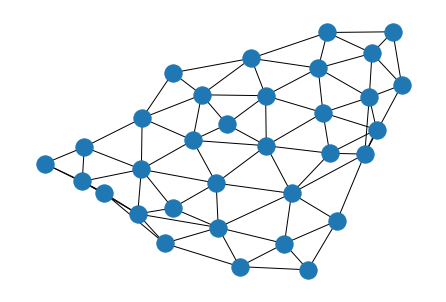

In [12]:
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(graph)

### Input feature processing to numpy arrays

Match up the date ranges for the income and NO2 data:

In [ ]:
def date_trim(df, start, end):
    df = df.loc[df.index >= start]
    df = df.loc[df.index <= end]
    return df

In [ ]:
start, end = daily_income_df.index.min(), daily_income_df.index.max()

aggregated_NO2_datetrim_df = date_trim(aggregated_NO2_df, start, end)
daily_met_datetrim_df = date_trim(daily_met_df, start, end)

In [ ]:
local_authority_list = [] 

for i in london_authorities_gdf.index:
    local_authority = london_authorities_gdf.iloc[i]["local_authority"]
    income_dataset_code = income_metadata_df.loc[income_metadata_df["local_authority"]==local_authority].index.values[0]
    daily_income_array = daily_income_df[income_dataset_code].values
    daily_NO2_array = aggregated_NO2_datetrim_df[local_authority].values
    node_array = np.array([daily_NO2_array, daily_income_array])
    local_authority_list.append(node_array)
input_array = np.array(local_authority_list)

In [ ]:
input_array.shape

In [ ]:
aggregated_NO2_df.columns